In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
import tensorflow

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Flatten, Input, Conv2D, LSTM, GRU, BatchNormalization, MaxPooling2D, Reshape
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
from numpy.random import seed
seed(13)
tensorflow.random.set_seed(2)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive


drive.mount('/content/gdrive')
current_path = os.path.join(os.getcwd(), 'gdrive/MyDrive')
dataset_path = os.path.join(current_path,"speech_commands_v0_02_dataset")
path_save_downsampled = os.path.join(current_path, "speech_commands_data/downsampled_dataset")
path_save_small = os.path.join(current_path, "speech_commands_data/small_dataset")


path_save_small_mfcc = os.path.join(path_save_small, 'mfcc')


Mounted at /content/gdrive


In [ ]:
os.listdir(path_save_small_mfcc)

['x_train_small_mfcc_0.npy',
 'x_val_small_mfcc_0.npy',
 'x_test_small_mfcc_0.npy',
 'x_train_small_mfcc_1.npy',
 'x_val_small_mfcc_1.npy',
 'x_test_small_mfcc_1.npy']

In [ ]:
def load_object(path_to_file):
  with open(path_to_file, "rb") as input_file:
    object = pickle.load(input_file)
  return object

def save_with_pickle(name_file, data, path_to_safe):
  with open(os.path.join(path_to_safe, name_file), "wb") as file:
      pickle.dump(data, file)

# Creation of classes

In [ ]:
small_train_label = load_object(os.path.join(path_save_small, 'cleaned_label_train_small.pickle'))
small_val_label = load_object(os.path.join(path_save_small, 'cleaned_label_val_small.pickle'))
small_test_label = load_object(os.path.join(path_save_small, 'cleaned_label_test_small.pickle'))

In [ ]:
commands_unkown_word = {"bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"}
commands = np.unique(small_train_label)

In [ ]:

def assign_num_to_command(commands, commands_unkown_word):
  """Assigns a number to each command. Commands belonging to commands_unkown_word
  will be assigned the same number (the last one).

  :param commands: List of all commands, including the ones that belong to
  command_unkown_word.
  :param commands_unkown_word: List of commands that belong to unknown word class.
  :return: Dictionary that maps each class with a number.
  """
  commands_numerical = {}

  c = 0
  for command in commands:
    if command not in commands_unkown_word:
      commands_numerical[str(command)] = c
      c += 1
    else:
      commands_numerical[str(command)] = len(commands) - len(commands_unkown_word)
  return(commands_numerical)

def create_label_numerical_array(labels):
  """Returns an array that has replaced the classes in "labels" by their
  assigned numbers.
  :param labels: List of labels (classes) of instances.
  :return: Array with the labels replaced by the corresponding number.
  """
  commands_numerical = assign_num_to_command(commands, commands_unkown_word)

  y_array = np.array(labels, dtype=object)
  for command in commands:
    y_array = np.where(y_array == command, commands_numerical[str(command)], y_array)
  return y_array


In [ ]:
label_train = create_label_numerical_array(small_train_label)

n_classes = len(set(label_train))

# One-hot encoding
y_train = to_categorical(label_train, num_classes=n_classes)
y_val = to_categorical(create_label_numerical_array(small_val_label), num_classes=n_classes)
y_test = to_categorical(create_label_numerical_array(small_test_label), num_classes=n_classes)


In [ ]:

classes = set(commands) - set(commands_unkown_word)
classes = np.unique(list(classes))
classes = np.append(classes, 'unkown_word')

# Load data

In [ ]:
small_train_data = np.load(os.path.join(path_save_small_mfcc, 'x_train_small_mfcc_1.npy'))
small_val_data = np.load(os.path.join(path_save_small_mfcc, 'x_val_small_mfcc_1.npy'))
small_test_data = np.load(os.path.join(path_save_small_mfcc, 'x_test_small_mfcc_1.npy'))


In [ ]:
small_train_data.shape

(13050, 13, 32)

In [ ]:
# Normalize data
train_shape = np.array(small_train_data).shape

x_train_flattened = small_train_data.flatten()

scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train_flattened.reshape(-1, 1))

x_train = x_train_normalized.reshape(train_shape)

def normalize_data(data, scaler):
  shape = data.shape
  data_flattened = data.flatten()
  data_normalized = scaler.transform(data_flattened.reshape(-1,1))
  return data_normalized.reshape(shape)


In [ ]:
x_train.shape

(13050, 13, 32)

In [ ]:
x_val = normalize_data(small_val_data, scaler)
x_test = normalize_data(small_test_data, scaler)

In [ ]:

input_shape = (13, 32, 1)

In [ ]:
input_shape

(13, 32, 1)

# Functions for evaluating model

In [ ]:
class MetricsInfoShower:
  """Class for showing reports and graphics regarding training and test
  evaluation."""

  def __init__(self, model, h_model, x, y_true, batch_size, classes) -> None:
    self.model = model
    self.h_model = h_model
    self.last_epoch = len(self.h_model.history['loss'])
    self.batch_size = batch_size
    self.y_true = np.argmax(y_test, axis=1)
    self.y_pred = self._get_y_pred(x)
    self.classes = classes



  def _get_y_pred(self, x):
    y_pred = self.model.predict(x, batch_size=self.batch_size)
    return y_pred.argmax(axis=1)

  def show_classification_report(self):
    # Evaluación del modelo
    print("[INFO]: Evaluando el modelo...")

    # Report
    print(classification_report(self.y_true, self.y_pred, target_names=self.classes))

  def show_confusion_matrix(self):
    # Calcula la matriz de confusión
    cm = confusion_matrix(self.y_true, self.y_pred, normalize='pred')

    # Crea un gráfico de matriz de confusión utilizando seaborn
    plt.figure(figsize = (16, 16))
    ax = sns.heatmap(cm, annot=True, cmap="PuBu", fmt=".2f", xticklabels=self.classes, yticklabels=classes, vmin = 0.1 )

    # Añade etiquetas y título
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.title("Matriz de Confusión")

    plt.show()

  def show_training_loss(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["loss"], label="train_loss")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

  def show_training_accuracy(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

  def show_all(self):
    self.show_training_loss()
    self.show_training_accuracy()
    self.show_classification_report()
    self.show_confusion_matrix()

### Experimento_A_cnn_mfcc_1_00

In [ ]:
exp_a_cnn_mfcc_1_00 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_1_00.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x, verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_1_00.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_1_00.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 64
h_exp_a_cnn_mfcc_1_00 = exp_a_cnn_mfcc_1_00.fit(x_train, y_train,
                                              batch_size=batch_size, epochs=50,
                                              validation_data=(x_val, y_val),
                                              callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1374 - loss: 2.9899
Epoch 1: val_loss improved from inf to 2.12633, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.1378 - loss: 2.9882 - val_accuracy: 0.3804 - val_loss: 2.1263 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/50
193/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4254 - loss: 1.9362
Epoch 2: val_loss improved from 2.12633 to 1.68692, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4270 - loss: 1.9303 - val_accuracy: 0.5117 - val_loss: 1.6869 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/50
196/204 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5606 - loss: 1.4890
Epoch 3: val_loss improved from 1.68692 to 1.39737, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5612 - loss: 1.4865 - val_accuracy: 0.5887 - val_loss: 1.3974 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/50
194/204 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6310 - loss: 1.2327
Epoch 4: val_loss improved from 1.39737 to 1.24901, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6316 - loss: 1.2310 - val_accuracy: 0.6249 - val_loss: 1.2490 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/50
198/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6770 - loss: 1.0736
Epoch 5: val_loss improved from 1.24901 to 1.16493, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6772 - loss: 1.0730 - val_accuracy: 0.6558 - val_loss: 1.1649 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/50
199/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7095 - loss: 0.9652
Epoch 6: val_loss improved from 1.16493 to 1.10251, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7095 - loss: 0.9648 - val_accuracy: 0.6762 - val_loss: 1.1025 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/50
202/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7338 - loss: 0.8848
Epoch 7: val_loss improved from 1.10251 to 1.05800, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7339 - loss: 0.8846 - val_accuracy: 0.6853 - val_loss: 1.0580 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/50
192/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7506 - loss: 0.8230
Epoch 8: val_loss improved from 1.05800 to 1.02528, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7507 - loss: 0.8225 - val_accuracy: 0.6913 - val_loss: 1.0253 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/50
191/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7713 - loss: 0.7738
Epoch 9: val_loss improved from 1.02528 to 1.01080, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7713 - loss: 0.7733 - val_accuracy: 0.6883 - val_loss: 1.0108 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/50
191/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7845 - loss: 0.7332
Epoch 10: val_loss improved from 1.01080 to 1.00076, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7845 - loss: 0.7328 - val_accuracy: 0.6974 - val_loss: 1.0008 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/50
194/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7933 - loss: 0.6984
Epoch 11: val_loss improved from 1.00076 to 0.99108, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7933 - loss: 0.6981 - val_accuracy: 0.6981 - val_loss: 0.9911 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/50
195/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8012 - loss: 0.6699
Epoch 12: val_loss improved from 0.99108 to 0.98644, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8012 - loss: 0.6696 - val_accuracy: 0.7019 - val_loss: 0.9864 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/50
193/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8088 - loss: 0.6442
Epoch 13: val_loss improved from 0.98644 to 0.98471, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8089 - loss: 0.6439 - val_accuracy: 0.7019 - val_loss: 0.9847 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/50
195/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8156 - loss: 0.6217
Epoch 14: val_loss improved from 0.98471 to 0.98050, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8157 - loss: 0.6215 - val_accuracy: 0.7004 - val_loss: 0.9805 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/50
192/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8198 - loss: 0.6029
Epoch 15: val_loss improved from 0.98050 to 0.97095, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8200 - loss: 0.6026 - val_accuracy: 0.7011 - val_loss: 0.9709 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/50
194/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8248 - loss: 0.5839
Epoch 16: val_loss improved from 0.97095 to 0.96444, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8249 - loss: 0.5838 - val_accuracy: 0.7049 - val_loss: 0.9644 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/50
198/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8288 - loss: 0.5679
Epoch 17: val_loss improved from 0.96444 to 0.95925, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8288 - loss: 0.5678 - val_accuracy: 0.7079 - val_loss: 0.9593 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/50
200/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8324 - loss: 0.5534
Epoch 18: val_loss improved from 0.95925 to 0.95515, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8325 - loss: 0.5534 - val_accuracy: 0.7072 - val_loss: 0.9551 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/50
190/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8354 - loss: 0.5414
Epoch 19: val_loss improved from 0.95515 to 0.95244, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8356 - loss: 0.5413 - val_accuracy: 0.7094 - val_loss: 0.9524 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8401 - loss: 0.5307
Epoch 20: val_loss improved from 0.95244 to 0.95087, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8401 - loss: 0.5307 - val_accuracy: 0.7102 - val_loss: 0.9509 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8463 - loss: 0.5215
Epoch 21: val_loss improved from 0.95087 to 0.94885, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8463 - loss: 0.5214 - val_accuracy: 0.7109 - val_loss: 0.9488 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/50
191/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8492 - loss: 0.5131
Epoch 22: val_loss improved from 0.94885 to 0.94762, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_00.h5


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8492 - loss: 0.5130 - val_accuracy: 0.7140 - val_loss: 0.9476 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/50
193/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8508 - loss: 0.5058
Epoch 23: val_loss did not improve from 0.94762
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8508 - loss: 0.5056 - val_accuracy: 0.7170 - val_loss: 0.9476 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/50
203/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8525 - loss: 0.4989
Epoch 24: val_loss did not improve from 0.94762
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8525 - loss: 0.4989 - val_accuracy: 0.7177 - val_loss: 0.9482 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/50
202/204 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [ ]:
exp_a_cnn_mfcc_1_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 11, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 5, 15, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 383,120 (1.46 MB)

 Trainable params: 127,706 (498.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 255,414 (997.71 KB)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


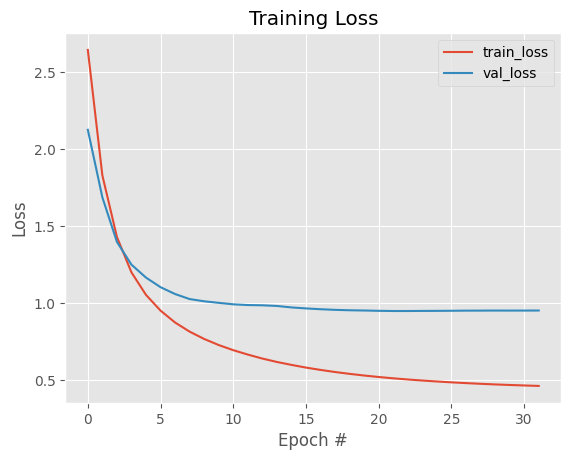

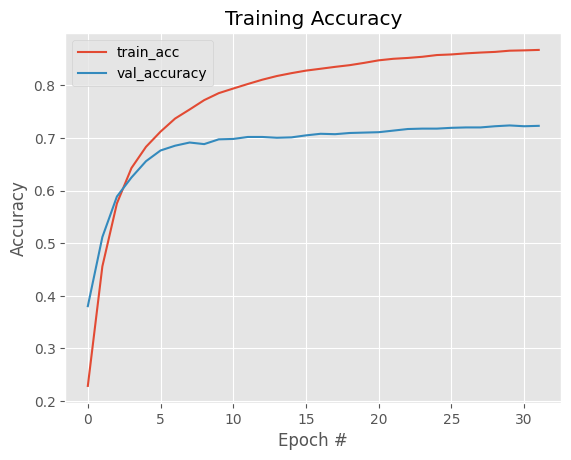

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.87      0.87      0.87        62
        down       0.64      0.52      0.57        62
       eight       0.81      0.87      0.84        62
        five       0.71      0.63      0.67        62
      follow       0.64      0.73      0.68        62
     forward       0.67      0.63      0.65        62
        four       0.67      0.60      0.63        62
          go       0.61      0.68      0.64        62
       learn       0.72      0.63      0.67        62
        left       0.73      0.76      0.75        62
        nine       0.69      0.79      0.74        62
          no       0.55      0.58      0.56        62
         off       0.75      0.73      0.74        62
          on       0.75      0.66      0.70        62
         one       0.82      0.81      0.81        62
       right       0.87      0.77      0.82        62
       seven       0.82      0.87      0.84       

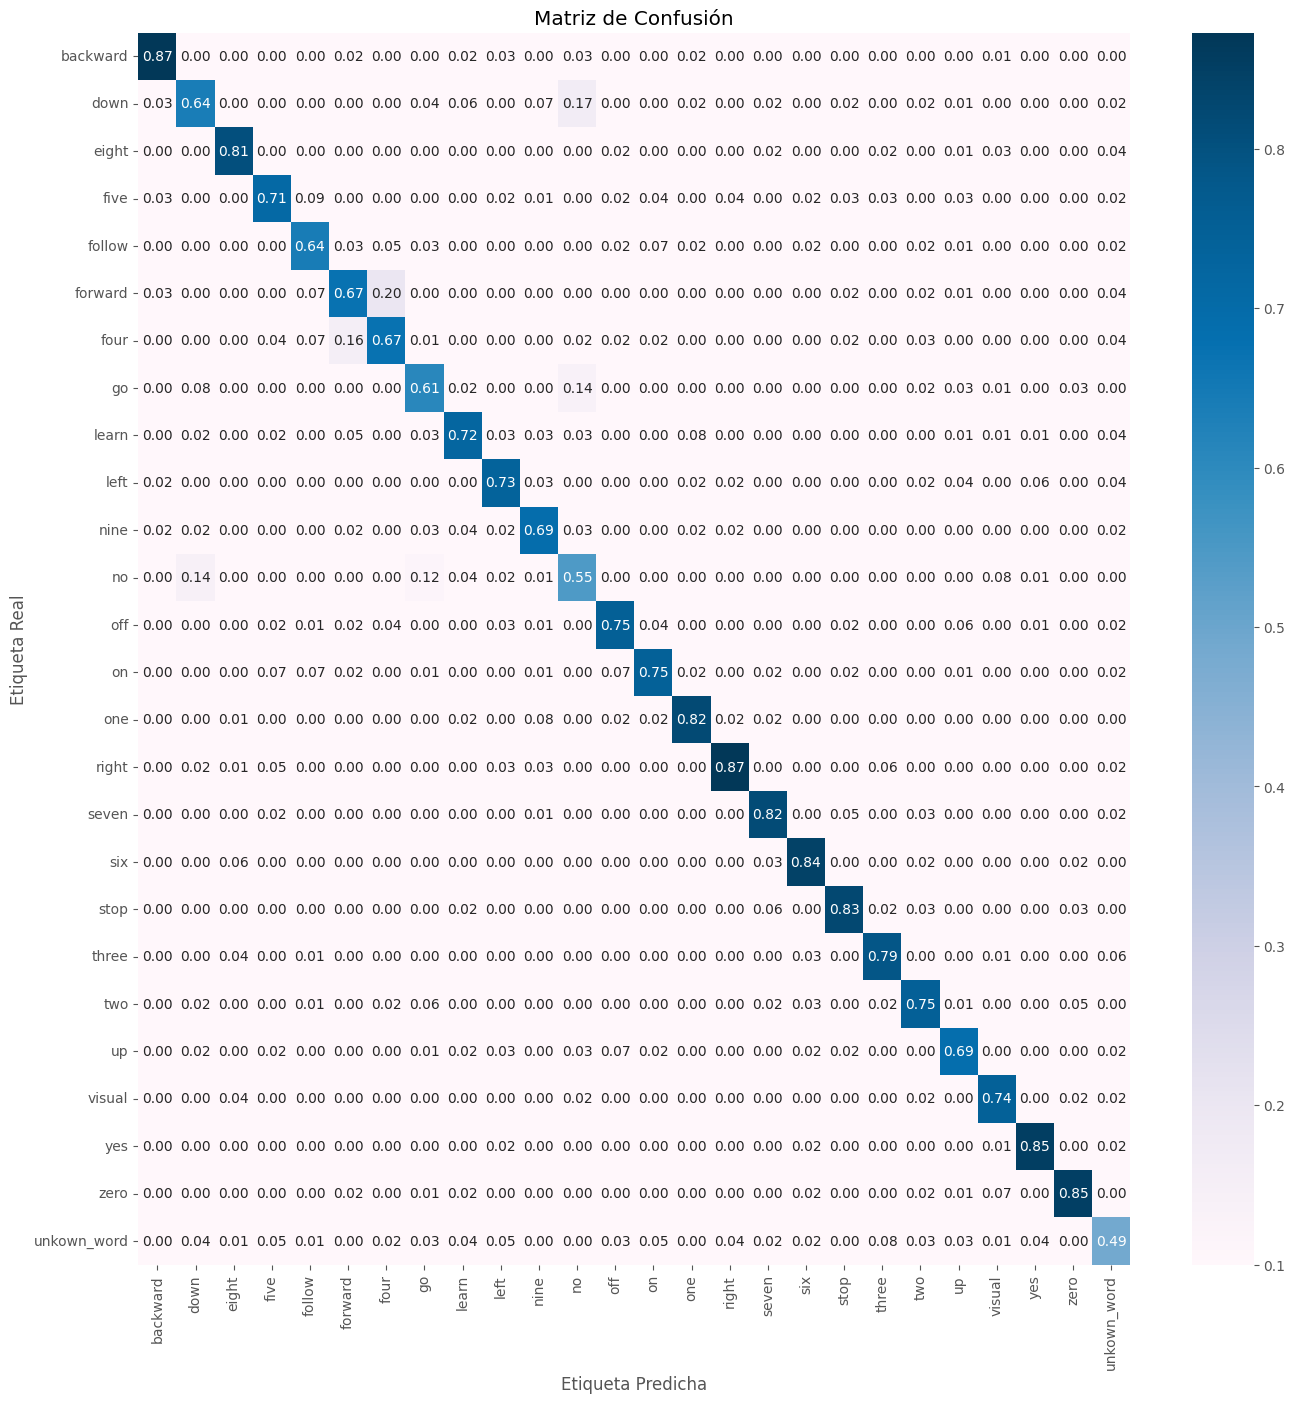

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_1_00, h_exp_a_cnn_mfcc_1_00, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_1_01

In [ ]:
exp_a_cnn_mfcc_1_01 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_1_01.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_1_01.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_1_01.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_1_01 = exp_a_cnn_mfcc_1_01.fit(x_train, y_train,
                                              batch_size=batch_size, epochs=90,
                                              validation_data=(x_val, y_val),
                                              callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2890 - loss: 2.5716
Epoch 1: val_loss improved from inf to 2.23588, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.2894 - loss: 2.5701 - val_accuracy: 0.3253 - val_loss: 2.2359 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6672 - loss: 1.0956
Epoch 2: val_loss improved from 2.23588 to 1.05907, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6675 - loss: 1.0949 - val_accuracy: 0.6875 - val_loss: 1.0591 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7698 - loss: 0.7543
Epoch 3: val_loss improved from 1.05907 to 0.92148, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_01.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7702 - loss: 0.7528 - val_accuracy: 0.7208 - val_loss: 0.9215 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8300 - loss: 0.5588
Epoch 4: val_loss did not improve from 0.92148
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8302 - loss: 0.5581 - val_accuracy: 0.7034 - val_loss: 0.9978 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8738 - loss: 0.4276
Epoch 5: val_loss did not improve from 0.92148
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8740 - loss: 0.4268 - val_accuracy: 0.7117 - val_loss: 0.9643 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9052

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9720 - loss: 0.1415 - val_accuracy: 0.7638 - val_loss: 0.8895 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9808 - loss: 0.1070
Epoch 10: val_loss did not improve from 0.88947
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9808 - loss: 0.1069 - val_accuracy: 0.7555 - val_loss: 0.9607 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9879 - loss: 0.0833
Epoch 11: val_loss did not improve from 0.88947
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9879 - loss: 0.0832 - val_accuracy: 0.7487 - val_loss: 1.0108 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [ ]:
exp_a_cnn_mfcc_1_01.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 11, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 11, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 15, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 13, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 384,656 (1.47 MB)

 Trainable params: 128,090 (500.35 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 256,182 (1000.71 KB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


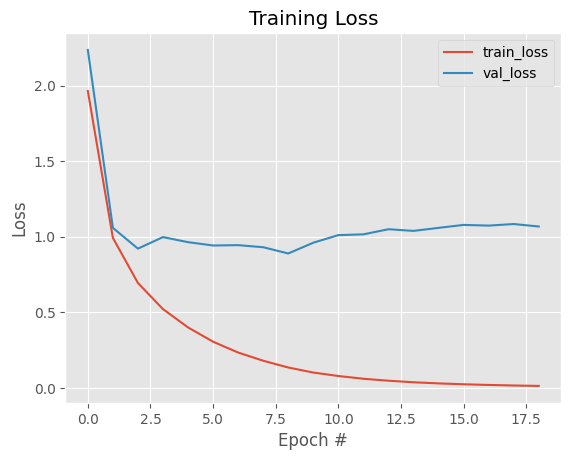

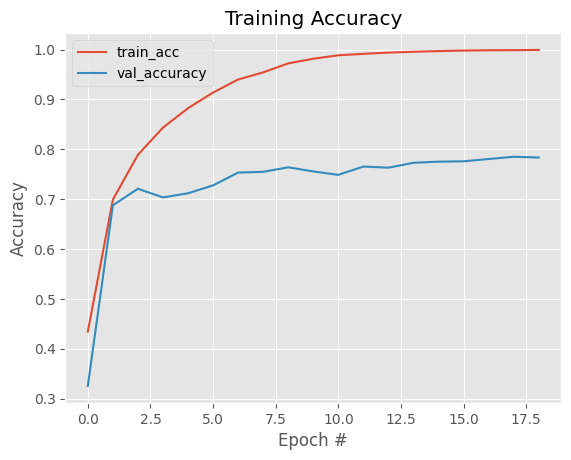

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.76      0.94      0.84        62
        down       0.75      0.74      0.75        62
       eight       0.93      0.84      0.88        62
        five       0.78      0.73      0.75        62
      follow       0.76      0.77      0.77        62
     forward       0.76      0.76      0.76        62
        four       0.82      0.65      0.72        62
          go       0.75      0.77      0.76        62
       learn       0.75      0.74      0.75        62
        left       0.78      0.87      0.82        62
        nine       0.81      0.82      0.82        62
          no       0.77      0.82      0.80        62
         off       0.84      0.77      0.81        62
          on       0.77      0.85      0.81        62
         one       0.79      0.85      0.82        62
       right       0.90      0.84      0.87        62
       seven       0.78      0.90      0.84       

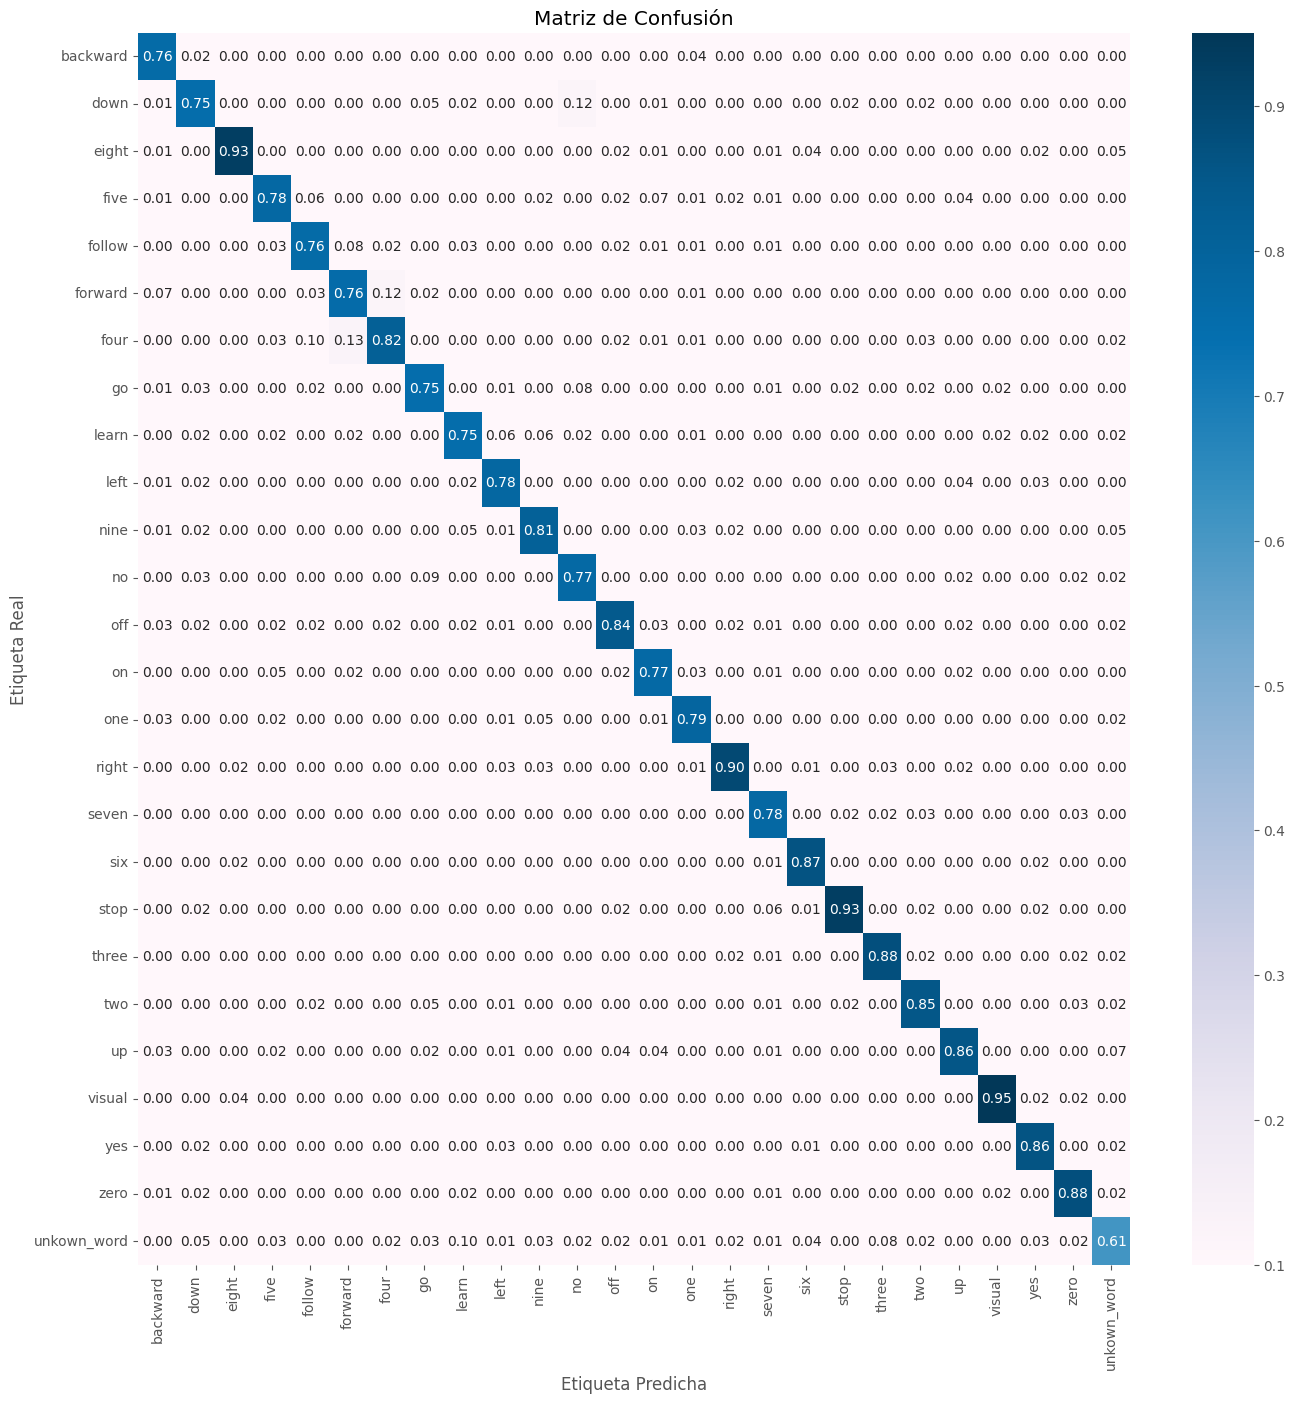

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_1_01, h_exp_a_cnn_mfcc_1_01, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_1_02

In [ ]:
exp_a_cnn_mfcc_1_02 = Sequential([
    # Primera capa convolucional
    Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Capa de salida
    Dense(n_classes, activation='softmax')])

exp_a_cnn_mfcc_1_02.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_1_02.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_1_02.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_1_02 = exp_a_cnn_mfcc_1_02.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0829 - loss: 3.3024
Epoch 1: val_loss improved from inf to 2.71206, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.0830 - loss: 3.3017 - val_accuracy: 0.2906 - val_loss: 2.7121 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2771 - loss: 2.3971
Epoch 2: val_loss improved from 2.71206 to 1.78059, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.2774 - loss: 2.3959 - val_accuracy: 0.4672 - val_loss: 1.7806 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4077 - loss: 1.9316
Epoch 3: val_loss improved from 1.78059 to 1.47103, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4081 - loss: 1.9302 - val_accuracy: 0.5774 - val_loss: 1.4710 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4818 - loss: 1.6513
Epoch 4: val_loss improved from 1.47103 to 1.20284, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4819 - loss: 1.6509 - val_accuracy: 0.6445 - val_loss: 1.2028 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5394 - loss: 1.4716
Epoch 5: val_loss improved from 1.20284 to 1.07816, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5396 - loss: 1.4711 - val_accuracy: 0.6845 - val_loss: 1.0782 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5792 - loss: 1.3137
Epoch 6: val_loss improved from 1.07816 to 1.00966, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5792 - loss: 1.3138 - val_accuracy: 0.6958 - val_loss: 1.0097 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6014 - loss: 1.2593
Epoch 7: val_loss improved from 1.00966 to 0.97331, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6015 - loss: 1.2591 - val_accuracy: 0.7162 - val_loss: 0.9733 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6444 - loss: 1.1497
Epoch 8: val_loss improved from 0.97331 to 0.89316, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6443 - loss: 1.1495 - val_accuracy: 0.7442 - val_loss: 0.8932 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6554 - loss: 1.0990
Epoch 9: val_loss improved from 0.89316 to 0.86089, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6555 - loss: 1.0988 - val_accuracy: 0.7426 - val_loss: 0.8609 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6689 - loss: 1.0502
Epoch 10: val_loss improved from 0.86089 to 0.85637, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6689 - loss: 1.0500 - val_accuracy: 0.7411 - val_loss: 0.8564 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6776 - loss: 1.0077
Epoch 11: val_loss improved from 0.85637 to 0.78785, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6778 - loss: 1.0075 - val_accuracy: 0.7577 - val_loss: 0.7878 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6906 - loss: 0.9661
Epoch 12: val_loss did not improve from 0.78785
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6907 - loss: 0.9659 - val_accuracy: 0.7517 - val_loss: 0.8061 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7034 - loss: 0.9341
Epoch 13: val_loss improved from 0.78785 to 0.78451, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7034 - loss: 0.9341 - val_accuracy: 0.7592 - val_loss: 0.7845 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7044 - loss: 0.9157
Epoch 14: val_loss improved from 0.78451 to 0.75565, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7045 - loss: 0.9156 - val_accuracy: 0.7615 - val_loss: 0.7556 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7134 - loss: 0.8886
Epoch 15: val_loss improved from 0.75565 to 0.75313, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7135 - loss: 0.8887 - val_accuracy: 0.7698 - val_loss: 0.7531 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7218 - loss: 0.8491
Epoch 16: val_loss improved from 0.75313 to 0.73065, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7218 - loss: 0.8492 - val_accuracy: 0.7766 - val_loss: 0.7307 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7310 - loss: 0.8230
Epoch 17: val_loss improved from 0.73065 to 0.71899, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7310 - loss: 0.8231 - val_accuracy: 0.7683 - val_loss: 0.7190 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7347 - loss: 0.8259
Epoch 18: val_loss did not improve from 0.71899
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7347 - loss: 0.8259 - val_accuracy: 0.7728 - val_loss: 0.7225 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7313 - loss: 0.8349
Epoch 19: val_loss improved from 0.71899 to 0.70807, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7313 - loss: 0.8348 - val_accuracy: 0.7826 - val_loss: 0.7081 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7460 - loss: 0.8022
Epoch 20: val_loss did not improve from 0.70807
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7460 - loss: 0.8022 - val_accuracy: 0.7826 - val_loss: 0.7187 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7468 - loss: 0.7777
Epoch 21: val_loss improved from 0.70807 to 0.68902, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7468 - loss: 0.7778 - val_accuracy: 0.7804 - val_loss: 0.6890 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7513 - loss: 0.7680
Epoch 22: val_loss did not improve from 0.68902
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7513 - loss: 0.7681 - val_accuracy: 0.7864 - val_loss: 0.6935 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7465 - loss: 0.7770
Epoch 23: val_loss improved from 0.68902 to 0.68077, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7468 - loss: 0.7768 - val_accuracy: 0.7925 - val_loss: 0.6808 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7544 - loss: 0.7660
Epoch 24: val_loss did not improve from 0.68077
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7544 - loss: 0.7660 - val_accuracy: 0.7879 - val_loss: 0.6860 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7623 - loss: 0.7427
Epoch 25: val_loss improved from 0.68077 to 0.67751, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7622 - loss: 0.7426 - val_accuracy: 0.7872 - val_loss: 0.6775 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7639 - loss: 0.7345
Epoch 26: val_loss improved from 0.67751 to 0.67572, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7638 - loss: 0.7348 - val_accuracy: 0.7894 - val_loss: 0.6757 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7539 - loss: 0.7580
Epoch 27: val_loss did not improve from 0.67572
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7541 - loss: 0.7577 - val_accuracy: 0.7864 - val_loss: 0.6779 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7577 - loss: 0.7523
Epoch 28: val_loss improved from 0.67572 to 0.67459, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7577 - loss: 0.7522 - val_accuracy: 0.7932 - val_loss: 0.6746 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7613 - loss: 0.7333
Epoch 29: val_loss did not improve from 0.67459
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7613 - loss: 0.7333 - val_accuracy: 0.7940 - val_loss: 0.6747 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7638 - loss: 0.7216
Epoch 30: val_loss improved from 0.67459 to 0.66941, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7638 - loss: 0.7218 - val_accuracy: 0.7940 - val_loss: 0.6694 - learning_rate: 4.7101e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.239115827521624e-05.
Epoch 31/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7671 - loss: 0.7165
Epoch 31: val_loss did not improve from 0.66941
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7671 - loss: 0.7165 - val_accuracy: 0.7909 - val_loss: 0.6708 - learning_rate: 4.2391e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.8152042447694614e-05.
Epoch 32/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7687 - loss: 0.7180
Epoch 32: val_loss did not improve from 0.66941
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7688 - loss: 0.7180 - val_accuracy: 0.7917 - val_loss: 0.6713 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7593 - loss: 0.7285 - val_accuracy: 0.7917 - val_loss: 0.6672 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7585 - loss: 0.7352
Epoch 34: val_loss improved from 0.66716 to 0.66269, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7586 - loss: 0.7351 - val_accuracy: 0.7917 - val_loss: 0.6627 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7662 - loss: 0.7110
Epoch 35: val_loss did not improve from 0.66269
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7662 - loss: 0.7110 - val_accuracy: 0.7932 - val_loss: 0.6672 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7691 - loss: 0.7219
Epoch 36: val_loss did not improve from 0.66269
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7691 - loss: 0.7219 - val_accuracy: 0.7917 - val_loss: 0.6680 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7685 - loss: 0.7053 - val_accuracy: 0.7894 - val_loss: 0.6620 - learning_rate: 1.6423e-05

Epoch 41: LearningRateScheduler setting learning rate to 1.4780882941434608e-05.
Epoch 41/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7705 - loss: 0.7069
Epoch 41: val_loss improved from 0.66204 to 0.66029, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7705 - loss: 0.7069 - val_accuracy: 0.7887 - val_loss: 0.6603 - learning_rate: 1.4781e-05

Epoch 42: LearningRateScheduler setting learning rate to 1.3302794647291146e-05.
Epoch 42/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7751 - loss: 0.6937
Epoch 42: val_loss improved from 0.66029 to 0.65986, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7751 - loss: 0.6937 - val_accuracy: 0.7909 - val_loss: 0.6599 - learning_rate: 1.3303e-05

Epoch 43: LearningRateScheduler setting learning rate to 1.1972515182562033e-05.
Epoch 43/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7733 - loss: 0.7057
Epoch 43: val_loss did not improve from 0.65986
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7733 - loss: 0.7057 - val_accuracy: 0.7894 - val_loss: 0.6612 - learning_rate: 1.1973e-05

Epoch 44: LearningRateScheduler setting learning rate to 1.077526366430583e-05.
Epoch 44/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7695 - loss: 0.7086
Epoch 44: val_loss did not improve from 0.65986
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7695 - loss: 0.7086 - val_accuracy: 0.7917 - val_loss: 0.6614 - learning_rate: 1.0775e-05

Epoch 45: LearningRateScheduler setting learning rate to 9.697737297875246e-06.
Epoch 45/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7766 - loss: 0.6955 - val_accuracy: 0.7902 - val_loss: 0.6596 - learning_rate: 7.8552e-06

Epoch 48: LearningRateScheduler setting learning rate to 7.069650490151056e-06.
Epoch 48/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7760 - loss: 0.6868
Epoch 48: val_loss did not improve from 0.65965
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7760 - loss: 0.6869 - val_accuracy: 0.7909 - val_loss: 0.6601 - learning_rate: 7.0697e-06

Epoch 49: LearningRateScheduler setting learning rate to 6.36268544113595e-06.
Epoch 49/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7740 - loss: 0.6883
Epoch 49: val_loss did not improve from 0.65965
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7740 - loss: 0.6884 - val_accuracy: 0.7894 - val_loss: 0.6597 - learning_rate: 6.3627e-06

Epoch 50: LearningRateScheduler setting learning rate to 5.726416897022355e-06.
Epoch 50/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7773 - loss: 0.6822 - val_accuracy: 0.7894 - val_loss: 0.6592 - learning_rate: 5.7264e-06

Epoch 51: LearningRateScheduler setting learning rate to 5.15377520732012e-06.
Epoch 51/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7752 - loss: 0.6950
Epoch 51: val_loss did not improve from 0.65919
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7752 - loss: 0.6949 - val_accuracy: 0.7902 - val_loss: 0.6598 - learning_rate: 5.1538e-06

Epoch 52: LearningRateScheduler setting learning rate to 4.638397686588108e-06.
Epoch 52/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7811 - loss: 0.6806
Epoch 52: val_loss did not improve from 0.65919
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7811 - loss: 0.6806 - val_accuracy: 0.7894 - val_loss: 0.6593 - learning_rate: 4.6384e-06

Epoch 53: LearningRateScheduler setting learning rate to 4.174557917929297e-06.
Epoch 53/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7751 - loss: 0.6995 - val_accuracy: 0.7902 - val_loss: 0.6592 - learning_rate: 2.7389e-06

Epoch 58: LearningRateScheduler setting learning rate to 2.465034704958071e-06.
Epoch 58/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7762 - loss: 0.6837
Epoch 58: val_loss improved from 0.65918 to 0.65899, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7762 - loss: 0.6837 - val_accuracy: 0.7902 - val_loss: 0.6590 - learning_rate: 2.4650e-06

Epoch 59: LearningRateScheduler setting learning rate to 2.218531234462264e-06.
Epoch 59/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7722 - loss: 0.6946
Epoch 59: val_loss improved from 0.65899 to 0.65881, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7722 - loss: 0.6946 - val_accuracy: 0.7909 - val_loss: 0.6588 - learning_rate: 2.2185e-06

Epoch 60: LearningRateScheduler setting learning rate to 1.9966781110160375e-06.
Epoch 60/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7677 - loss: 0.6998
Epoch 60: val_loss did not improve from 0.65881
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7677 - loss: 0.6998 - val_accuracy: 0.7909 - val_loss: 0.6590 - learning_rate: 1.9967e-06

Epoch 61: LearningRateScheduler setting learning rate to 1.797010299914434e-06.
Epoch 61/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7724 - loss: 0.6928
Epoch 61: val_loss improved from 0.65881 to 0.65858, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_02.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7724 - loss: 0.6930 - val_accuracy: 0.7902 - val_loss: 0.6586 - learning_rate: 1.7970e-06

Epoch 62: LearningRateScheduler setting learning rate to 1.6173092699229906e-06.
Epoch 62/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7712 - loss: 0.6968
Epoch 62: val_loss did not improve from 0.65858
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7713 - loss: 0.6968 - val_accuracy: 0.7902 - val_loss: 0.6590 - learning_rate: 1.6173e-06

Epoch 63: LearningRateScheduler setting learning rate to 1.4555783429306915e-06.
Epoch 63/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7732 - loss: 0.6905
Epoch 63: val_loss did not improve from 0.65858
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7732 - loss: 0.6906 - val_accuracy: 0.7902 - val_loss: 0.6588 - learning_rate: 1.4556e-06

Epoch 64: LearningRateScheduler setting learning rate to 1.3100205086376223e-06.
Epoch 64/90
400/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

In [ ]:
exp_a_cnn_mfcc_1_02.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 11, 30, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 15, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 15, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 13, 64)           │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 13, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,432 (1.54 MB)

 Trainable params: 134,682 (526.10 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 269,366 (1.03 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


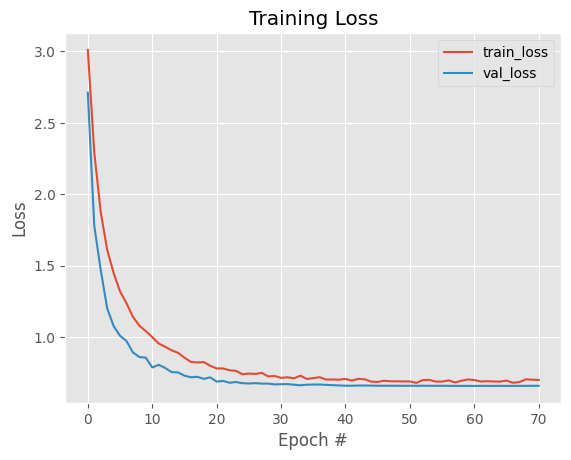

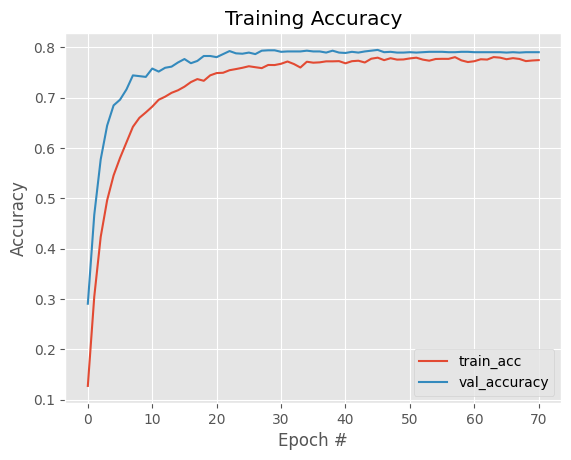

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.91      0.97      0.94        62
        down       0.82      0.73      0.77        62
       eight       0.91      0.94      0.92        62
        five       0.81      0.74      0.77        62
      follow       0.65      0.74      0.69        62
     forward       0.68      0.66      0.67        62
        four       0.71      0.68      0.69        62
          go       0.73      0.74      0.74        62
       learn       0.75      0.73      0.74        62
        left       0.83      0.79      0.81        62
        nine       0.88      0.90      0.89        62
          no       0.69      0.84      0.76        62
         off       0.93      0.84      0.88        62
          on       0.78      0.81      0.79        62
         one       0.87      0.85      0.86        62
       right       0.93      0.85      0.89        62
       seven       0.79      0.90      0.84       

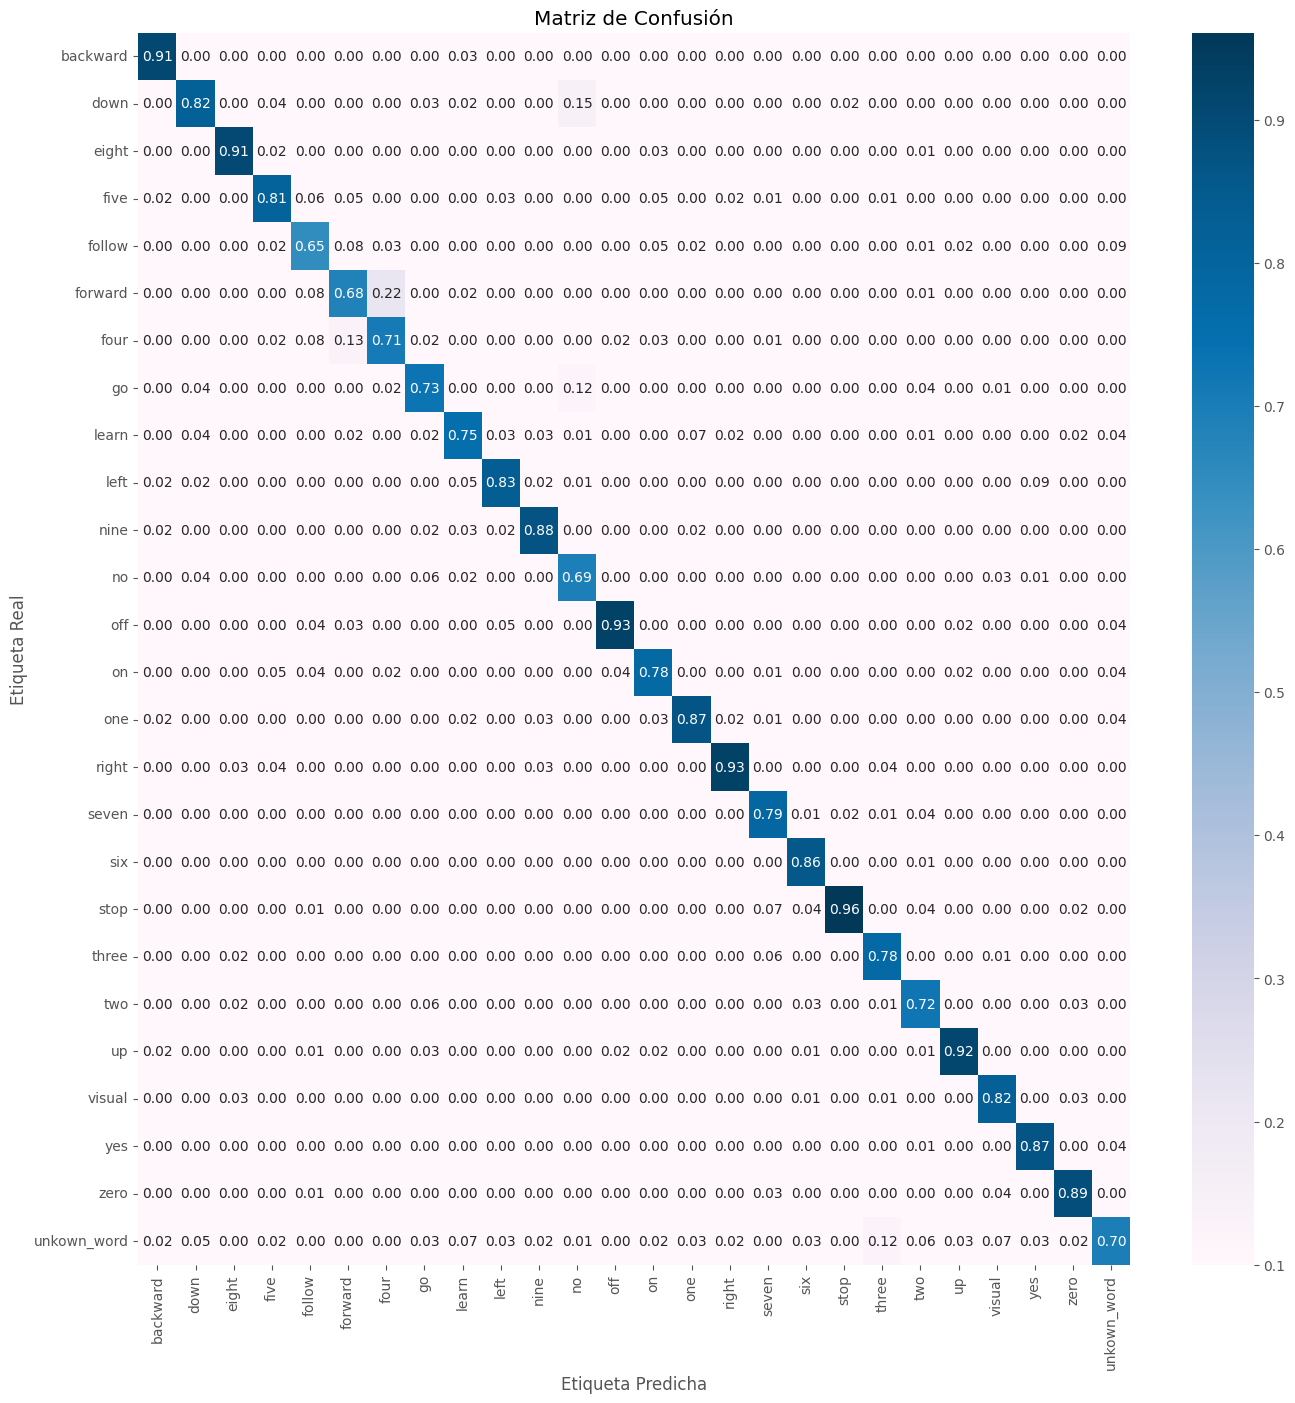

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_1_02, h_exp_a_cnn_mfcc_1_02, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_A_cnn_mfcc_1_03

In [ ]:
exp_a_cnn_mfcc_1_03 = Sequential([
    # Primera capa convolucional
    Conv2D(256, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Capa de salida
    Dense(n_classes, activation='softmax')
])

exp_a_cnn_mfcc_1_03.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_small, 'models/exp_a_cnn_mfcc_1_03.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_small, 'log/exp_a_cnn_mfcc_1_03.csv'))

In [ ]:
y_train.shape

(13050, 26)

In [ ]:
# Train
batch_size = 32
h_exp_a_cnn_mfcc_1_03 = exp_a_cnn_mfcc_1_03.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0982 - loss: 3.0696
Epoch 1: val_loss improved from inf to 2.12938, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.0984 - loss: 3.0690 - val_accuracy: 0.3608 - val_loss: 2.1294 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3555 - loss: 2.1162
Epoch 2: val_loss improved from 2.12938 to 1.62438, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3561 - loss: 2.1141 - val_accuracy: 0.5117 - val_loss: 1.6244 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4782 - loss: 1.6679
Epoch 3: val_loss improved from 1.62438 to 1.37178, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4782 - loss: 1.6677 - val_accuracy: 0.5864 - val_loss: 1.3718 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5456 - loss: 1.4452
Epoch 4: val_loss improved from 1.37178 to 1.22017, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5458 - loss: 1.4447 - val_accuracy: 0.6196 - val_loss: 1.2202 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 1.2822
Epoch 5: val_loss improved from 1.22017 to 1.16772, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 1.2820 - val_accuracy: 0.6423 - val_loss: 1.1677 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6205 - loss: 1.1874
Epoch 6: val_loss improved from 1.16772 to 1.14982, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6205 - loss: 1.1874 - val_accuracy: 0.6483 - val_loss: 1.1498 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6464 - loss: 1.1185
Epoch 7: val_loss improved from 1.14982 to 1.04682, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6465 - loss: 1.1185 - val_accuracy: 0.6740 - val_loss: 1.0468 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
398/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6643 - loss: 1.0560
Epoch 8: val_loss improved from 1.04682 to 0.98745, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6644 - loss: 1.0557 - val_accuracy: 0.6943 - val_loss: 0.9875 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6789 - loss: 0.9982
Epoch 9: val_loss improved from 0.98745 to 0.95497, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6790 - loss: 0.9984 - val_accuracy: 0.7117 - val_loss: 0.9550 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6952 - loss: 0.9609
Epoch 10: val_loss improved from 0.95497 to 0.93010, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6952 - loss: 0.9609 - val_accuracy: 0.7208 - val_loss: 0.9301 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7058 - loss: 0.9202
Epoch 11: val_loss improved from 0.93010 to 0.92171, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7058 - loss: 0.9202 - val_accuracy: 0.7192 - val_loss: 0.9217 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7042 - loss: 0.9090
Epoch 12: val_loss improved from 0.92171 to 0.90156, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7042 - loss: 0.9090 - val_accuracy: 0.7253 - val_loss: 0.9016 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7137 - loss: 0.8808
Epoch 13: val_loss improved from 0.90156 to 0.89518, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7137 - loss: 0.8808 - val_accuracy: 0.7238 - val_loss: 0.8952 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7238 - loss: 0.8621
Epoch 14: val_loss improved from 0.89518 to 0.88516, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7238 - loss: 0.8621 - val_accuracy: 0.7283 - val_loss: 0.8852 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
393/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7257 - loss: 0.8397
Epoch 15: val_loss improved from 0.88516 to 0.88491, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7259 - loss: 0.8394 - val_accuracy: 0.7245 - val_loss: 0.8849 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7310 - loss: 0.8325
Epoch 16: val_loss improved from 0.88491 to 0.88103, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7310 - loss: 0.8324 - val_accuracy: 0.7328 - val_loss: 0.8810 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7352 - loss: 0.8141
Epoch 17: val_loss improved from 0.88103 to 0.87222, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7353 - loss: 0.8137 - val_accuracy: 0.7343 - val_loss: 0.8722 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
404/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7428 - loss: 0.7948
Epoch 18: val_loss improved from 0.87222 to 0.86912, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7428 - loss: 0.7948 - val_accuracy: 0.7366 - val_loss: 0.8691 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
401/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7485 - loss: 0.7863
Epoch 19: val_loss did not improve from 0.86912
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7484 - loss: 0.7863 - val_accuracy: 0.7366 - val_loss: 0.8725 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7426 - loss: 0.7770
Epoch 20: val_loss did not improve from 0.86912
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7428 - loss: 0.7769 - val_accuracy: 0.7343 - val_loss: 0.8766 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7528 - loss: 0.7619 - val_accuracy: 0.7328 - val_loss: 0.8686 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7540 - loss: 0.7613
Epoch 22: val_loss improved from 0.86859 to 0.86238, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7540 - loss: 0.7610 - val_accuracy: 0.7396 - val_loss: 0.8624 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7494 - loss: 0.7557
Epoch 23: val_loss improved from 0.86238 to 0.85684, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7495 - loss: 0.7556 - val_accuracy: 0.7389 - val_loss: 0.8568 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
403/408 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7556 - loss: 0.7556
Epoch 24: val_loss improved from 0.85684 to 0.85467, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7556 - loss: 0.7555 - val_accuracy: 0.7442 - val_loss: 0.8547 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7637 - loss: 0.7292
Epoch 25: val_loss improved from 0.85467 to 0.84275, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7637 - loss: 0.7293 - val_accuracy: 0.7464 - val_loss: 0.8428 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
402/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7653 - loss: 0.7143
Epoch 26: val_loss did not improve from 0.84275
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7653 - loss: 0.7146 - val_accuracy: 0.7419 - val_loss: 0.8460 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7675 - loss: 0.7208
Epoch 27: val_loss did not improve from 0.84275
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7674 - loss: 0.7210 - val_accuracy: 0.7442 - val_loss: 0.8469 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7684 - loss: 0.7134 - val_accuracy: 0.7404 - val_loss: 0.8426 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7683 - loss: 0.7119
Epoch 34: val_loss did not improve from 0.84257
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7683 - loss: 0.7119 - val_accuracy: 0.7411 - val_loss: 0.8432 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7742 - loss: 0.6963
Epoch 35: val_loss improved from 0.84257 to 0.84089, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7741 - loss: 0.6964 - val_accuracy: 0.7396 - val_loss: 0.8409 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7670 - loss: 0.7060
Epoch 36: val_loss improved from 0.84089 to 0.83982, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7670 - loss: 0.7059 - val_accuracy: 0.7411 - val_loss: 0.8398 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
395/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7639 - loss: 0.6988
Epoch 37: val_loss improved from 0.83982 to 0.83868, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7642 - loss: 0.6988 - val_accuracy: 0.7404 - val_loss: 0.8387 - learning_rate: 2.2528e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0275559590445276e-05.
Epoch 38/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7771 - loss: 0.7018
Epoch 38: val_loss did not improve from 0.83868
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7770 - loss: 0.7017 - val_accuracy: 0.7419 - val_loss: 0.8420 - learning_rate: 2.0276e-05

Epoch 39: LearningRateScheduler setting learning rate to 1.824800363140075e-05.
Epoch 39/90
406/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7695 - loss: 0.7057
Epoch 39: val_loss improved from 0.83868 to 0.83759, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7696 - loss: 0.7056 - val_accuracy: 0.7434 - val_loss: 0.8376 - learning_rate: 1.8248e-05

Epoch 40: LearningRateScheduler setting learning rate to 1.6423203268260675e-05.
Epoch 40/90
407/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7776 - loss: 0.6884
Epoch 40: val_loss did not improve from 0.83759
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7776 - loss: 0.6884 - val_accuracy: 0.7411 - val_loss: 0.8410 - learning_rate: 1.6423e-05

Epoch 41: LearningRateScheduler setting learning rate to 1.4780882941434608e-05.
Epoch 41/90
399/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7741 - loss: 0.6926
Epoch 41: val_loss did not improve from 0.83759
408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7741 - loss: 0.6925 - val_accuracy: 0.7442 - val_loss: 0.8394 - learning_rate: 1.4781e-05

Epoch 42: LearningRateScheduler setting learning rate to 1.3302794647291146e-05.
Epoch 42/90
405/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7719 - loss: 0.6991 - val_accuracy: 0.7404 - val_loss: 0.8373 - learning_rate: 1.1973e-05

Epoch 44: LearningRateScheduler setting learning rate to 1.077526366430583e-05.
Epoch 44/90
397/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7744 - loss: 0.7043
Epoch 44: val_loss improved from 0.83730 to 0.83640, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7744 - loss: 0.7041 - val_accuracy: 0.7419 - val_loss: 0.8364 - learning_rate: 1.0775e-05

Epoch 45: LearningRateScheduler setting learning rate to 9.697737297875246e-06.
Epoch 45/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7692 - loss: 0.6990
Epoch 45: val_loss did not improve from 0.83640
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7693 - loss: 0.6988 - val_accuracy: 0.7449 - val_loss: 0.8387 - learning_rate: 9.6977e-06

Epoch 46: LearningRateScheduler setting learning rate to 8.727963568087722e-06.
Epoch 46/90
408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7782 - loss: 0.6917
Epoch 46: val_loss improved from 0.83640 to 0.83495, saving model to /content/gdrive/MyDrive/speech_commands_data/small_dataset/models/exp_a_cnn_mfcc_1_03.h5


408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7782 - loss: 0.6917 - val_accuracy: 0.7434 - val_loss: 0.8349 - learning_rate: 8.7280e-06

Epoch 47: LearningRateScheduler setting learning rate to 7.85516721127895e-06.
Epoch 47/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7735 - loss: 0.6941
Epoch 47: val_loss did not improve from 0.83495
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7736 - loss: 0.6938 - val_accuracy: 0.7434 - val_loss: 0.8368 - learning_rate: 7.8552e-06

Epoch 48: LearningRateScheduler setting learning rate to 7.069650490151056e-06.
Epoch 48/90
394/408 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7711 - loss: 0.6996
Epoch 48: val_loss did not improve from 0.83495
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7712 - loss: 0.6994 - val_accuracy: 0.7426 - val_loss: 0.8367 - learning_rate: 7.0697e-06

Epoch 49: LearningRateScheduler setting learning rate to 6.36268544113595e-06.
Epoch 49/90
396/408 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

In [ ]:
exp_a_cnn_mfcc_1_03.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 11, 30, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 5, 15, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 13, 64)           │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 627,920 (2.40 MB)

 Trainable params: 209,306 (817.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 418,614 (1.60 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


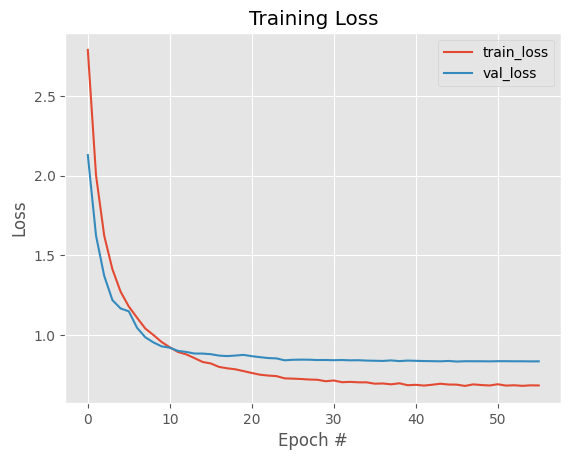

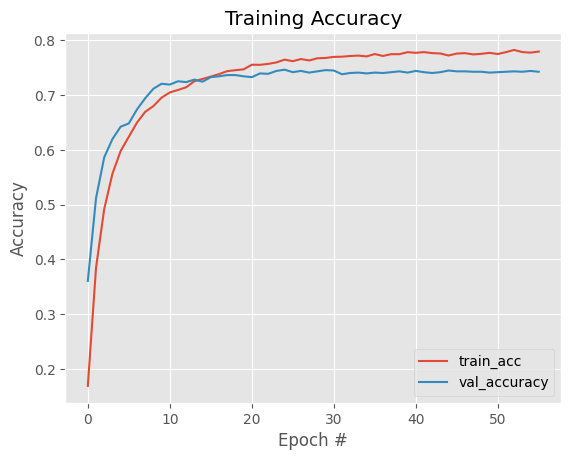

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.85      0.89      0.87        62
        down       0.72      0.58      0.64        62
       eight       0.86      0.92      0.89        62
        five       0.69      0.56      0.62        62
      follow       0.62      0.63      0.62        62
     forward       0.58      0.56      0.57        62
        four       0.65      0.65      0.65        62
          go       0.66      0.60      0.63        62
       learn       0.66      0.63      0.64        62
        left       0.78      0.73      0.75        62
        nine       0.79      0.84      0.81        62
          no       0.57      0.74      0.65        62
         off       0.87      0.73      0.79        62
          on       0.71      0.77      0.74        62
         one       0.87      0.87      0.87        62
       right       0.94      0.81      0.87        62
       seven       0.82      0.89      0.85       

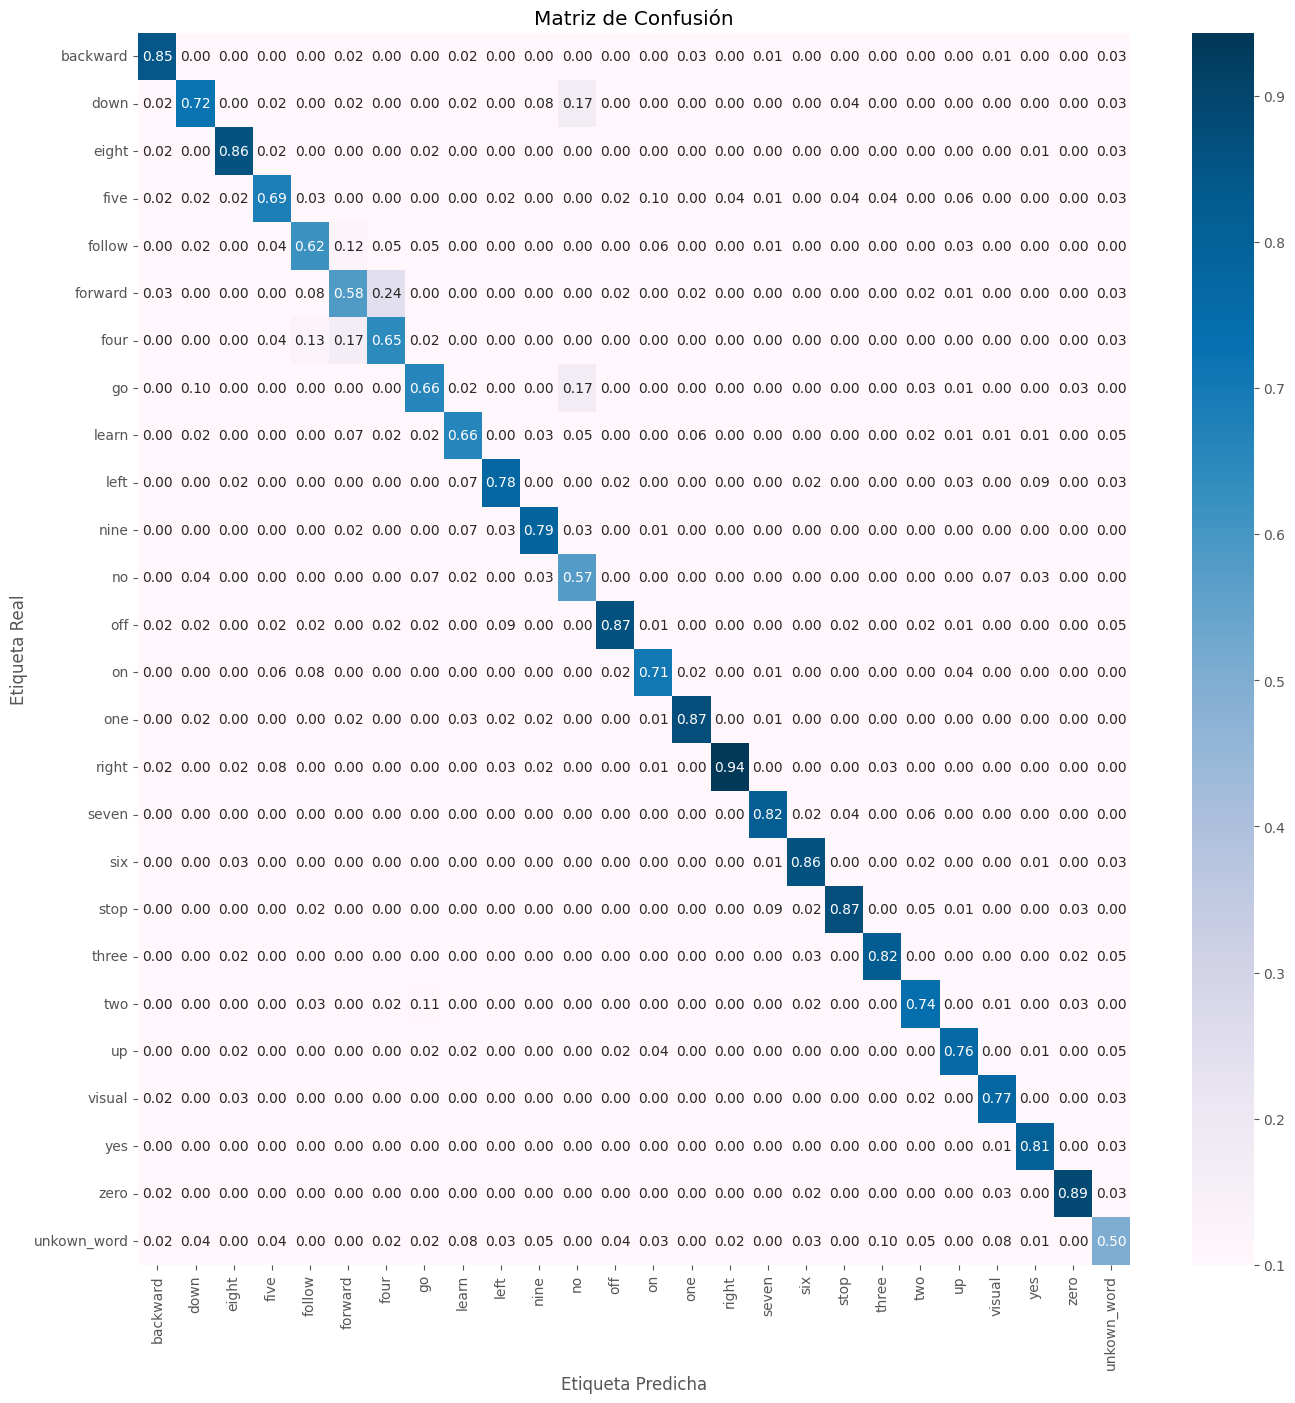

In [ ]:
mis = MetricsInfoShower(exp_a_cnn_mfcc_1_03, h_exp_a_cnn_mfcc_1_03, x_test, y_test, batch_size, classes)
mis.show_all()